In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [36]:
# Generatorの定義
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 64*64*4),  # RGBA画像のサイズに合わせる
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 4, 64, 64)  # RGBA画像の形式に変換
        return img

In [37]:
# Discriminatorの定義
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(64*64*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [38]:
class RGBADataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.image_paths = [os.path.join(root, f) for f in os.listdir(root) if os.path.isfile(os.path.join(root, f))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGBA")
        if self.transform:
            image = self.transform(image)
        return image

In [55]:
# データセットの読み込み
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])
dataset = RGBADataset(root="SkinData/data/alex/", transform=transform)
print(len(dataset))

42


[Epoch 99/100] [Batch 40/42] [D loss: 0.6025956273078918] [G loss: 0.6997801065444946]]]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Epoch 99/100] [Batch 41/42] [D loss: 0.510093092918396] [G loss: 0.7216558456420898]

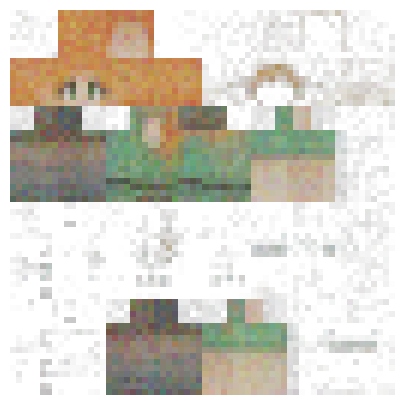

In [107]:
# ハイパーパラメータ
latent_dim = 100
lr = 0.0003
batch_size = 1
n_epochs = 100

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# モデルの初期化
generator = Generator(latent_dim)
discriminator = Discriminator()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator.to(device)
discriminator.to(device)

# 損失関数と最適化手法の定義
adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

images = np.array([])
# 学習ループ
for epoch in range(n_epochs):
    for i, imgs in enumerate(dataloader):
        real_imgs = imgs.to(device)
        # Generatorの学習
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), torch.ones(batch_size, 1).to(device))
        g_loss.backward()
        optimizer_G.step()

        real_labels = torch.ones(real_imgs.size(0), 1).to(device)
        fake_labels = torch.zeros(gen_imgs.size(0), 1).to(device)

        # Discriminatorの学習
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real_labels)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()
        
        print(f"\r[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]",end="")

z = torch.randn(25, latent_dim)
gen_imgs = generator(z)
gen_imgs = gen_imgs.view(gen_imgs.size(0), 4, 64, 64)
plt.figure(figsize=(5, 5))
plt.imshow(gen_imgs[gen_imgs.size(0)-1].cpu().detach().numpy().transpose(1, 2, 0))
plt.axis('off')

dir_path = "Created_Skin/"
files = os.listdir(dir_path)
img = cv2.cvtColor(gen_imgs[gen_imgs.size(0)-1].cpu().detach().numpy().transpose(1, 2, 0)*255, cv2.COLOR_RGB2BGRA)
cv2.imwrite(f"{dir_path}ai_{len(files)+1}.png", img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

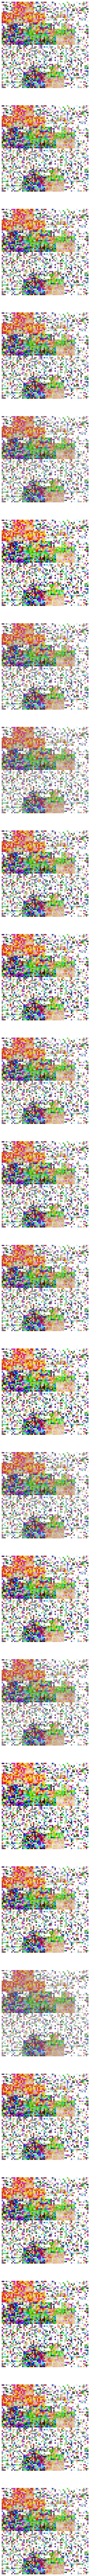

In [106]:
z = torch.randn(25, latent_dim)
gen_imgs = generator(z)
gen_imgs = gen_imgs.view(gen_imgs.size(0), 4, 64, 64)
plt.figure(figsize=(200, 200))
for k in range(gen_imgs.size(0)):
    plt.subplot(25, 1, k+1)
    plt.imshow(gen_imgs[k].cpu().detach().numpy().transpose(1, 2, 0))
    plt.axis('off')
plt.show()